In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# from nltk.tokenize import word_tokenize as wt 
# from collections import Counter
import gensim
# import textblob
import spacy
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Embedding, GRU

## **Plan of Action**

- Load the data
- Drop unnecessary columns and rows
- Removal of stop words.
- Feature engineering;
    - Doc2Vec
- Begin modelling
    - Algorithms to use;
        - Simple Neural Network
- Evaluation;
    - F1-score_macro
    - AUC
    - ROC

In [2]:
df_clean = pd.read_csv('../../cleaned_reviews.csv')

In [3]:
df_clean.shape

(17340, 4)

In [4]:
df_clean.columns

Index(['sentiments', 'cleaned_review', 'cleaned_review_length',
       'review_score'],
      dtype='object')

In [5]:
df_clean.drop(columns=['cleaned_review_length','review_score'],inplace=True)

Checking for Null Vaules and Duplicates

In [6]:
df_clean.isna().sum()

sentiments        0
cleaned_review    3
dtype: int64

In [7]:
df_clean.dropna(inplace=True)

In [8]:
df_clean.shape

(17337, 2)

In [9]:
from spacy.lang.en.stop_words import STOP_WORDS

# print(STOP_WORDS,'\n') # <- set of Spacy's default stop words
all_stopwords = STOP_WORDS
# Adding several stopwords
# all_stopwords |= {'not',"no", "n't", 'n’t','n‘t','cannot','none','without','against'}

# Removing several stop words
all_stopwords-= {'not',"no", "n't", 'n’t','n‘t','cannot','none','without','against','off','against','too'}
my_stop_words = set(all_stopwords) # My own stop words

In [10]:
# print(my_stop_words)

In [11]:
df_clean

,sentiments,cleaned_review
0,positive,i wish would have gotten one earlier love it a...
1,neutral,i ve learned this lesson again open the packag...
2,neutral,it is so slow and lags find better option
3,neutral,roller ball stopped working within months of m...
4,neutral,i like the color and size but it few days out ...
...,...,...
17335,positive,i love this speaker and love can take it anywh...
17336,positive,i use it in my house easy to connect and loud ...
17337,positive,the bass is good and the battery is amazing mu...
17338,positive,love it


In [12]:
nlp = spacy.load("en_core_web_sm")

In [13]:
def spacy_tokeniser(sent):
    sent = sent.strip().lower()
    doc = nlp(sent)
    mytokens = [token.lemma_ for token in doc if token.text not in my_stop_words]
    return mytokens

In [14]:
df_clean['tokens']= df_clean['cleaned_review'].apply(spacy_tokeniser)

In [15]:
df_clean.head()

,sentiments,cleaned_review,tokens
0,positive,i wish would have gotten one earlier love it a...,"[wish, get, early, love, make, work, laptop, e..."
1,neutral,i ve learned this lesson again open the packag...,"[ve, learn, lesson, open, package, use, produc..."
2,neutral,it is so slow and lags find better option,"[slow, lag, find, well, option]"
3,neutral,roller ball stopped working within months of m...,"[roller, ball, stop, work, month, minimal, use..."
4,neutral,i like the color and size but it few days out ...,"[like, color, size, day, return, period, not, ..."


In [16]:
# Dropping unnecessary columns
df_clean.drop(columns=['cleaned_review'],inplace=True)

Sentiment Mapping

In [17]:
sentiment_mapping = {'negative':0,'neutral':1,'positive':2}
df_clean['sentiment_label'] = df_clean.sentiments.map(sentiment_mapping)

In [18]:
df_clean.drop(columns=['sentiments'],inplace=True)

In [19]:
df_clean

,tokens,sentiment_label
0,"[wish, get, early, love, make, work, laptop, e...",2
1,"[ve, learn, lesson, open, package, use, produc...",1
2,"[slow, lag, find, well, option]",1
3,"[roller, ball, stop, work, month, minimal, use...",1
4,"[like, color, size, day, return, period, not, ...",1
...,...,...
17335,"[love, speaker, love, charge, phone, work, no,...",2
17336,"[use, house, easy, connect, loud, clear, music]",2
17337,"[bass, good, battery, amazing, well, charge, t...",2
17338,[love],2


### **Text Sequencing**

In [20]:
X = df_clean["tokens"]

In [21]:
X[0]

['wish', 'get', 'early', 'love', 'make', 'work', 'laptop', 'easy']

In [22]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X)

X = word_tokenizer.texts_to_sequences(X)
X[0]

[153, 26, 758, 9, 124, 1, 51, 34]

In [23]:
# We need to find the maximum lenght of any document or review in our case. 
# We will pad all reviews to have this same length.
# This will be required by Keras embedding layer

review_max_length = 0
for i in df_clean['tokens']: 
    length = len(i)
    if length > review_max_length:
        review_max_length = length

print(review_max_length) 

# Although max length is 293, we will use an approximate value of 300; 
# maxlen = 300

293


In [24]:
# print(word_tokenizer.word_index) # Outputs a dictionary
len(word_tokenizer.word_index)

7258

In [25]:
vocab = word_tokenizer.word_index.items()

In [26]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

7259

In [27]:
max_len = 300
X = pad_sequences(X,padding="post",maxlen=max_len)

In [28]:
X[1].shape # shape
X[1].ndim # dimension

1

### **Doc2Vec Processing**

In [29]:
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

*Do not split but do the following;*

- Create the text sequence before Doc2Vec Processing
- Train using df_clean for Doc2Vec vocabulary building
- Then follow the same pattern you used for the embedding matrix

In [30]:
tagged_process = df_clean
# Tag train set 
tagged_process_train = tagged_process.apply(
    lambda x: TaggedDocument(words=x["tokens"],tags=[x.sentiment_label]),
    axis=1
)

In [31]:
tagged_process_train.values[0]

TaggedDocument(words=['wish', 'get', 'early', 'love', 'make', 'work', 'laptop', 'easy'], tags=[2])

In [32]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores # Mine is 8 cores
four_cores = cores-4
four_cores

4

**Building the Vocabulary**

In [33]:
# dm=1, it signifies PV-DM
model_dm = Doc2Vec(
    dm=1,
    vector_size=200,
    min_count=2,
    sample=0,
    workers=four_cores,
    hs=0,
    seed= 42,
    negative=5,
    alpha=0.05,# Changing alpha from 0.025 to 0.05
    dm_mean=1 # to make use of mean
)

In [34]:
model_dm.build_vocab(tagged_process_train)

In [35]:
# Word Apperance Count
def word_count(word:str):
    print(f"Word {word} appeared {model_dm.wv.get_vecattr(word, 'count')} times in the corpus.")


word_count("terrible")

Word terrible appeared 158 times in the corpus.


In [36]:
model_dm.train(
                tagged_process_train,
                total_examples=model_dm.corpus_count,
                epochs=100,
)

In [37]:
model_dm.wv.get_vector("like").shape # vector shape 
model_dm.wv.vector_size # vector size

200

In [38]:
model_dm["like"].shape

(200,)

In [39]:
# model_dm["like"] # prints out the vector

### **Creating Embedding Matrix**

In [40]:
d2v_vector_size  =model_dm.vector_size
embedding_matrix = np.zeros((vocab_length, d2v_vector_size)) 
print(embedding_matrix.shape) # (7259, 200)
print(embedding_matrix.ndim) # 2-dimensional array

(7259, 200)
2


In [41]:
embedding_matrix[:5,:2]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [42]:
# model_dm.wv.key_to_index.keys()
# # prints a list of keys like so dict_keys(['work', 'mouse', 'not', 'great',

In [43]:
for word, index in vocab:
    if word in model_dm.wv.key_to_index.keys():
        embedding_matrix[index] = model_dm[word]
    else:
        embedding_matrix[index] = np.zeros(d2v_vector_size)

In [44]:
embedding_matrix[:10,:10]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.19143279,  0.74042445,  0.23588055, -0.07579236, -0.66416681,
         0.23762456,  0.35359535, -0.60308933,  0.16981806,  0.25321695],
       [ 0.84820735,  0.8008526 , -1.07139838,  0.82287472,  0.33216169,
         0.11207919, -0.19011796,  0.32866967, -0.20776944,  0.78196198],
       [ 1.01934564,  0.70796931,  0.30296391,  0.48255312,  0.57131058,
        -0.21051885, -1.14954877, -0.38449886, -0.47072792, -0.46519697],
       [-0.44450733, -0.9569459 , -0.71794343,  0.14277491,  0.95354456,
        -0.76520818,  0.03650946,  0.16988574,  0.5770784 , -0.38744062],
       [-0.95148093, -0.61568648, -0.31952447,  0.94542664,  0.75965106,
         0.21264935,  0.74092972,  0.18902938,  0.27126512,  1.38331056],
       [-0.5313471 ,  1.07329953, -0.10011286,  0.11361682, -0.49395391,
         1.82394421, -0.87601197,  0.1434723 

### **Model Building**

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
y_nn = tf.keras.utils.to_categorical(df_clean.sentiment_label.values, num_classes=3, dtype='int8')

In [47]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y_nn,test_size=.2,random_state=42, 
                                            stratify=y_nn)

In [48]:
gru_model = Sequential()
embedding_layer = Embedding(vocab_length,d2v_vector_size,weights=[embedding_matrix],
                                        input_length=max_len,trainable=False)


gru_model.add(embedding_layer)
gru_model.add(GRU(128))
gru_model.add(Dense(3,activation='softmax'))
gru_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [49]:
gru_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

print(gru_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 200)          1451800   
                                                                 
 gru (GRU)                   (None, 128)               126720    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,578,907
Trainable params: 127,107
Non-trainable params: 1,451,800
_________________________________________________________________
None


In [50]:
# Model training

gru_model_history = gru_model.fit(
    X_train,y_train,batch_size=128,epochs=10, verbose=1, validation_split=.2
)

Epoch 1/10
87/87 [==============================] - 21s 183ms/step - loss: 0.9335 - acc: 0.5443 - val_loss: 0.9200 - val_acc: 0.5397
Epoch 2/10
87/87 [==============================] - 15s 176ms/step - loss: 0.9118 - acc: 0.5502 - val_loss: 0.9201 - val_acc: 0.5397
Epoch 3/10
87/87 [==============================] - 14s 162ms/step - loss: 0.9110 - acc: 0.5502 - val_loss: 0.9196 - val_acc: 0.5397
Epoch 4/10
87/87 [==============================] - 14s 160ms/step - loss: 0.9116 - acc: 0.5502 - val_loss: 0.9202 - val_acc: 0.5397
Epoch 5/10
87/87 [==============================] - 14s 161ms/step - loss: 0.9119 - acc: 0.5502 - val_loss: 0.9198 - val_acc: 0.5397
Epoch 6/10
87/87 [==============================] - 13s 153ms/step - loss: 0.9115 - acc: 0.5502 - val_loss: 0.9192 - val_acc: 0.5397
Epoch 7/10
87/87 [==============================] - 14s 157ms/step - loss: 0.9116 - acc: 0.5502 - val_loss: 0.9203 - val_acc: 0.5397
Epoch 8/10
87/87 [==============================] - 14s 161ms/step - 

In [51]:
# Predictions on the Test Set

score = gru_model.evaluate(X_test, y_test, verbose=1)

109/109 [==============================] - 3s 25ms/step - loss: 0.9158 - acc: 0.5482


In [52]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.9158081412315369
Test Accuracy: 0.5481545329093933


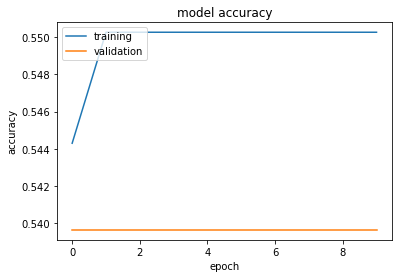

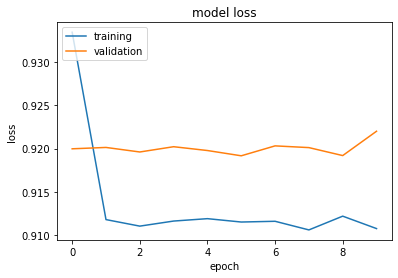

In [53]:
# Model Performance Charts

plt.plot(gru_model_history.history['acc'])
plt.plot(gru_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

plt.plot(gru_model_history.history['loss'])
plt.plot(gru_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

### **Classification report**

In [54]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
y_pred =   np.argmax(gru_model.predict(X_test), axis  =  1)
y_true = np.argmax(y_test, axis = 1)

print(classification_report(y_true,y_pred))

109/109 [==============================] - 3s 23ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       307
           1       0.00      0.00      0.00      1260
           2       0.55      1.00      0.71      1901

    accuracy                           0.55      3468
   macro avg       0.18      0.33      0.24      3468
weighted avg       0.30      0.55      0.39      3468



109/109 [==============================] - 2s 21ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       307
           1       0.00      0.00      0.00      1260
           2       0.55      1.00      0.71      1901

    accuracy                           0.55      3468
   macro avg       0.18      0.33      0.24      3468
weighted avg       0.30      0.55      0.39      3468



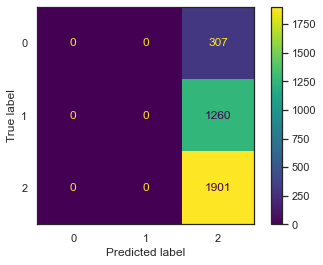

In [55]:
# Classification report test data

y_true=np.argmax(y_test, axis=1)
y_pred_test = gru_model.predict(X_test)
y_pred_test=np.argmax(y_pred_test, axis=1)
sns.set_theme(style='white')
def class_report(model,y_true,pred):
    print(classification_report(y_true,pred))
    cm = confusion_matrix(y_true,pred,labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
    disp.plot()
    plt.show()


class_report(gru_model,y_true,y_pred_test) 

# Original mapping
# sentiment_mapping = {'negative':-1,'neutral':0,'positive':1}

# New mapping
# negative --> 0
# neutral --> 1
# positive --> 2

### **ROC Curve**

In [56]:
from sklearn.preprocessing import label_binarize

In [57]:
n_classes = 3

y_nn_auc = label_binarize(y_nn, classes=[0,1,2])

n_classes = y_nn_auc.shape[1]

In [58]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y_nn_auc,test_size=.2,random_state=42, 
                                            stratify=y_nn_auc)

In [59]:
gru_model = Sequential()
embedding_layer = Embedding(vocab_length,d2v_vector_size,weights=[embedding_matrix],
                                        input_length=max_len,trainable=False)


gru_model.add(embedding_layer)
gru_model.add(GRU(128))
gru_model.add(Dense(3,activation='softmax'))
gru_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

print(gru_model.summary())
# Model training

gru_model_history = gru_model.fit(
    X_train,y_train,batch_size=128,epochs=10, verbose=1, validation_split=.2
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 200)          1451800   
                                                                 
 gru_1 (GRU)                 (None, 128)               126720    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,578,907
Trainable params: 127,107
Non-trainable params: 1,451,800
_________________________________________________________________
None
Epoch 1/10
87/87 [==============================] - 17s 167ms/step - loss: 0.9325 - acc: 0.5456 - val_loss: 0.9205 - val_acc: 0.5397
Epoch 2/10
87/87 [==============================] - 14s 156ms/step - loss: 0.9118 - acc: 0.5502 - val_loss: 0.9212 - val_acc: 0.5397
Epoch 3/10
87/87 [=============

In [60]:
from sklearn.metrics import roc_curve, roc_auc_score,auc
fpr = {}
tpr = {}
roc_auc = {}
# Plot linewidth
lw = 2

# Version 2
classes_by_names = ["negative","neutral","positive"]
def roc_curve_plot(value,y_test):
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], 
                                                    value[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])                                                    
        plt.plot(fpr[i], tpr[i], lw=lw, label= "ROC of class {}, AUC= {}"
        .format(classes_by_names[i],np.round(roc_auc[i],2)))
        
       
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="best",frameon=True) # ,labels=["negative","neutral","positive"]
    # Title should be modified
    plt.title("ROC curve of GRU multiclass; Sentiment prediction")
    plt.show()
    roc_auc_scoring_macro_ovr = roc_auc_score(y_test,value, multi_class="OvR",average='macro')
    print("AUC macro-averaged over all classes: {:.2f}"
    .format(roc_auc_scoring_macro_ovr))

In [61]:
y_pred_test = gru_model.predict(X_test)
# y_pred_test=np.argmax(y_pred_test, axis=1)

109/109 [==============================] - 3s 25ms/step


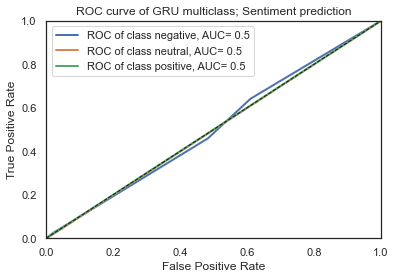

AUC macro-averaged over all classes: 0.50


In [62]:
roc_curve_plot(y_pred_test,y_test)

## **Conclusion**

- Using PV-DM-200 word embeddings with GRU has also showed complete failure in performance.
- Logistic Regression using Doc2Vec PV-DM-200 has an f1-score of 0.67 and AUC score of 0.85.


**Table of Values**

dataset|f1_score_macro_avg|AUC_score_avg
| ----------- | ----------- | ----------- |
df_clean (test data)|0.24|0.50